# *Coffe Classifier: Thesis project for Bythem*

## Imports

In [35]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [36]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from src.preprocessing import dataset_preprocessing, mixup, tensorflow_to_numpy_dataset
from src.custom_mobilenet_v2 import MobileNet_v2
from src.plotting import plot_training_history, plotting_confusion_matrix
from src.utils import get_zipped_model_size, print_model_weights_sparsity
from src.evaluation import evaluate_lite_model
from src.distiller import Distiller, WarmUpCosine

## Configurations

In [37]:
DATASET_PATH = "../dataset_04"

MODEL_NAME = "prova_04"
DISTILLED_MODEL_NAME = "distilled_prova_04"
PRUNED_MODEL_NAME = "pruned_prova_04"
QUANTIZED_MODEL_NAME = "quantized_prova_04"

SAVE = True

## Dataset loading and preprocessing

In [38]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
SCALE = 127.5
OFFSET = -1

In [39]:
dataset = keras.utils.image_dataset_from_directory(DATASET_PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.80,
                                                                              validation_size=0.1, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

Found 1281 files belonging to 9 classes.


In [40]:
class_names, number_classes

(['cioccolata',
  'cioccolata senza paletta',
  'errore',
  'espresso',
  'espresso senza paletta',
  'macchiato',
  'macchiato senza paletta',
  'the',
  'the senza paletta'],
 9)

In [41]:
print('Number of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Number of training images: 1024
Number of validation images: 128
Number of testing images: 192


In [42]:
example_epochs = 2
dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE
total_steps = steps_per_epoch * example_epochs
warm_up_steps = 0.75*total_steps

print("Total steps: ", total_steps )
print("Warm-up steps: ", warm_up_steps )

Total steps:  32
Warm-up steps:  24.0


## **Transfer learning model**

In [43]:
DROPOUT = 0.2
FREEZING_PERCENTAGE = 1
EPOCHS = 100

Load pre-trained model

In [44]:
pre_trained_model = keras.applications.MobileNetV2(input_shape = INPUT_SHAPE, 
                                                   include_top=False, 
                                                   weights='imagenet',
                                                   alpha=0.35,
                                                   classes=number_classes)

Set weights from pre_trained model and freeze a % of the pre-trained model for transfer learning

In [45]:
model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT)

count = 0
for i, layer in enumerate(pre_trained_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        count = count +1 

for i in range(int(count*FREEZING_PERCENTAGE)):
    model.layers[i].trainable= False

Compile and train model

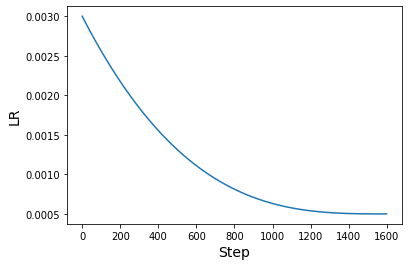

In [46]:
dataset_num_train_examples = len(training_dataset)*BATCH_SIZE
steps_per_epoch = dataset_num_train_examples // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS

learning_rate_fn = keras.optimizers.schedules.PolynomialDecay(
    3e-3,
    total_steps,
    5e-4,
    power=3)

import matplotlib.pyplot as plt
import numpy as np

lrs = learning_rate_fn(np.arange(0,total_steps))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [47]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate_fn),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(training_dataset, validation_data=validation_dataset,epochs=EPOCHS)
                    #callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 51s 2s/step - loss: 1.8528 - accuracy: 0.3861 - val_loss: 1.5005 - val_accuracy: 0.4922
Epoch 2/100
16/16 [==============================] - 8s 532ms/step - loss: 1.1555 - accuracy: 0.5286 - val_loss: 0.9363 - val_accuracy: 0.5703
Epoch 3/100
16/16 [==============================] - 9s 575ms/step - loss: 0.7228 - accuracy: 0.7076 - val_loss: 0.6073 - val_accuracy: 0.7891
Epoch 4/100
16/16 [==============================] - 10s 638ms/step - loss: 0.5149 - accuracy: 0.7929 - val_loss: 0.4911 - val_accuracy: 0.8203
Epoch 5/100
16/16 [==============================] - 9s 580ms/step - loss: 0.4114 - accuracy: 0.8460 - val_loss: 0.4064 - val_accuracy: 0.7969
Epoch 6/100
16/16 [==============================] - 9s 578ms/step - loss: 0.3681 - accuracy: 0.8481 - val_loss: 0.3582 - val_accuracy: 0.8438
Epoch 7/100
16/16 [==============================] - 9s 577ms/step - loss: 0.3080 - accuracy: 0.8866 - val_loss: 0.3071 - val_accuracy: 0.8984


Plotting training history

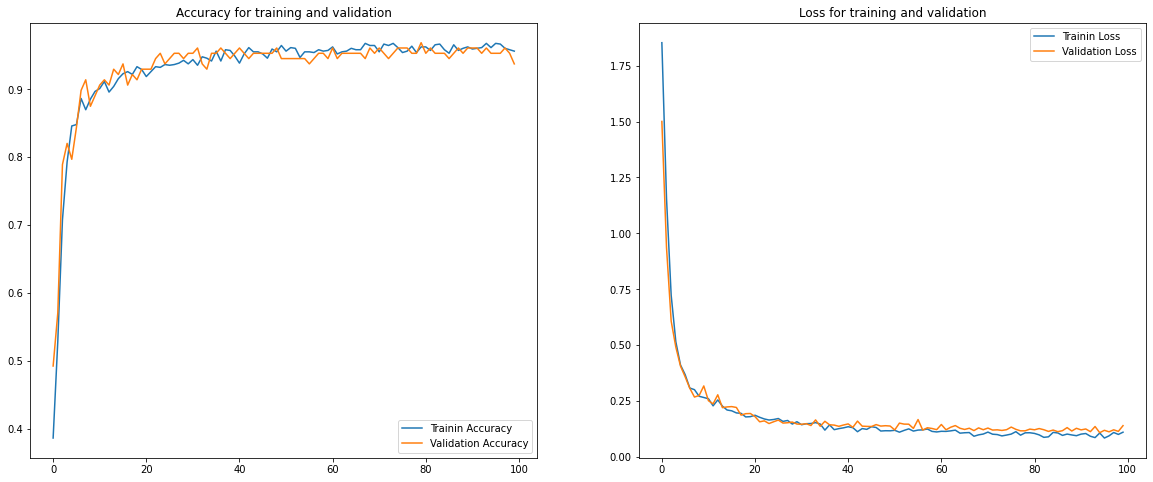

In [48]:
plot_training_history(history)

Test model

In [49]:
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Accuracy: ', round(baseline_accuracy*100, 3), '%')

Accuracy:  97.396 %


6/6 [==============================] - 8s 240ms/step


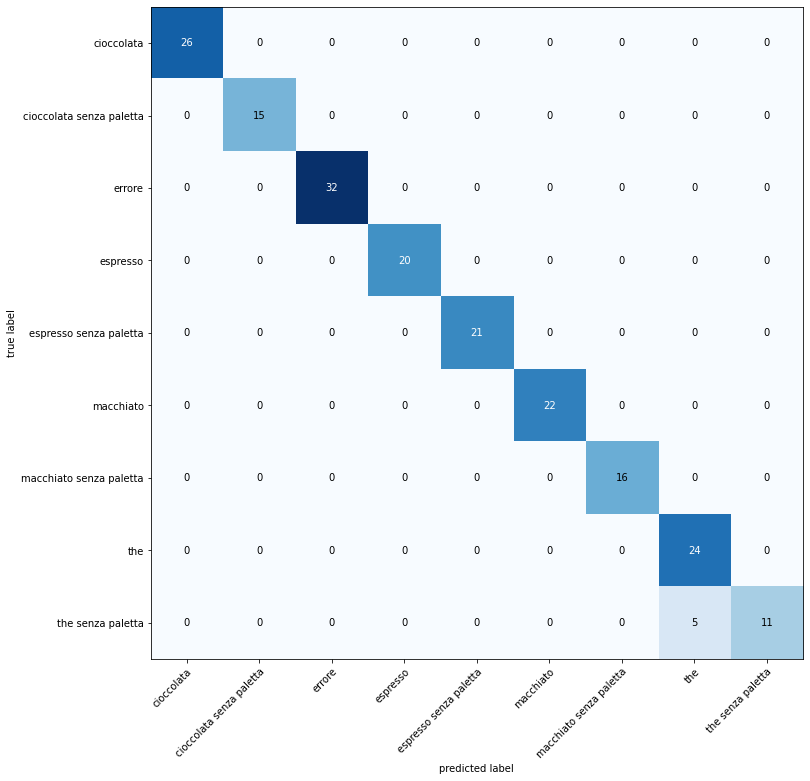

In [50]:
plotting_confusion_matrix(testing_dataset, model, class_names)

In [51]:
if SAVE:
    model.save('saved_models/' + MODEL_NAME + '.keras')
    print("Salvato")

Salvato


## **Knowladge distillation**

In [52]:
DISTILLATION_EPOCHS = 2
WARMUP_STEPS = 24
INIT_LR = 0.003

In [53]:
total_steps = steps_per_epoch * DISTILLATION_EPOCHS
warm_up_steps = 0.75*total_steps

In [54]:
teacher_model = keras.models.load_model('saved_models/' + MODEL_NAME + '.keras')

teacher_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

student_model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT, minimization=True)

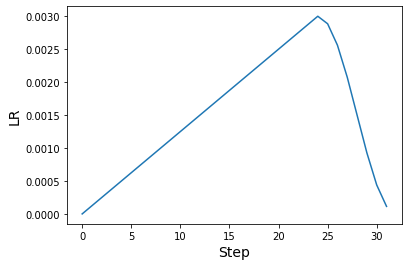

In [55]:
lr_schedule = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS,
)

lrs = lr_schedule(np.arange(0,total_steps))
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [56]:
mixup_training_dataset = training_dataset.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)

In [57]:
distiller = Distiller(student=student_model, teacher= teacher_model, alpha=0.1, temperature=10)

distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss = keras.losses.KLDivergence()
)

history = distiller.fit(mixup_training_dataset, epochs= DISTILLATION_EPOCHS, validation_data= validation_dataset)

Epoch 1/2


C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tf_keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 92s 3s/step - sparse_categorical_accuracy: 0.1322 - student_loss: 2.1894 - distillation_loss: 4.3031e-04 - val_sparse_categorical_accuracy: 0.1641 - val_student_loss: 2.1964
Epoch 2/2
16/16 [==============================] - 44s 3s/step - sparse_categorical_accuracy: 0.2622 - student_loss: 2.0262 - distillation_loss: 3.8124e-04 - val_sparse_categorical_accuracy: 0.1641 - val_student_loss: 2.1963


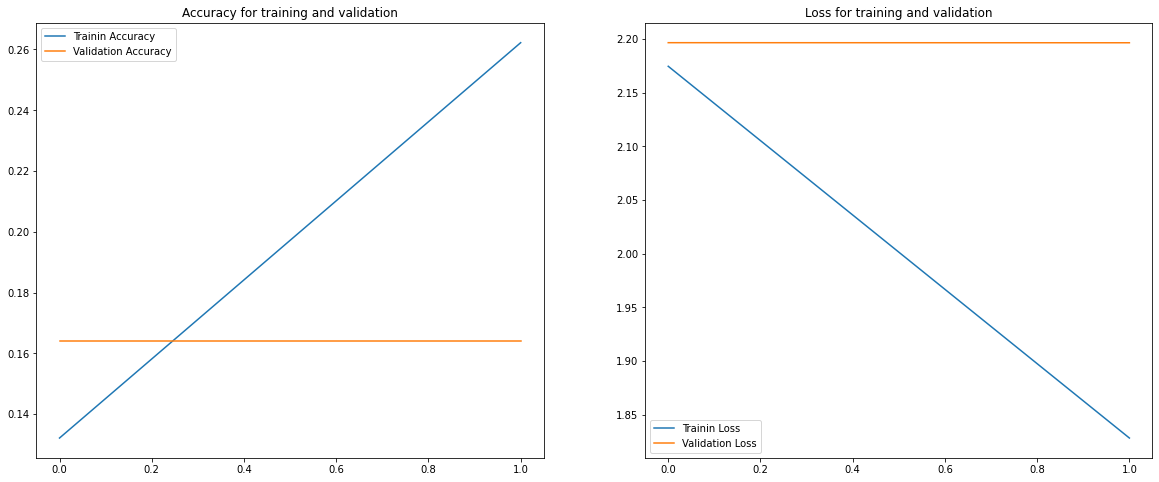

In [58]:
training_accuracy = history.history['sparse_categorical_accuracy']
validation_accuracy = history.history['val_sparse_categorical_accuracy']
training_loss = history.history['student_loss']
validation_loss = history.history['val_student_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy,   label = 'Trainin Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy for training and validation')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss,   label = 'Trainin Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.legend()
plt.title('Loss for training and validation')

plt.show()

In [59]:
student_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

_, teacher_accuracy = teacher_model.evaluate(testing_dataset, verbose = 0)
_, student_accuracy = student_model.evaluate(testing_dataset, verbose = 0)
print('Teacher model accuracy: ', round(teacher_accuracy*100, 3), '%')
print('Student model accuracy: ', round(student_accuracy*100, 3), '%')

Teacher model accuracy:  97.396 %
Student model accuracy:  16.667 %


In [60]:
if SAVE:
    student_model.save('saved_models/' + DISTILLED_MODEL_NAME + '.keras')

## **Pruned Model**

In [61]:
PRUNING_EPOCHS = 3
INITIAL_SPARSITY = 0.20
FINAL_SPARSITY = 0.60
FREQUENCY = 30

In [62]:
model = keras.models.load_model('saved_models/' + MODEL_NAME + '.keras')

In [63]:
model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [64]:
model.trainable= True

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = (len(training_dataset)) *BATCH_SIZE
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * PRUNING_EPOCHS

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=INITIAL_SPARSITY, 
                                                             final_sparsity=FINAL_SPARSITY,
                                                             begin_step=0, 
                                                             end_step=end_step,
                                                             frequency = FREQUENCY)}


pruned_model = prune_low_magnitude(model, **pruning_params)

callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

pruned_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-5),
                     loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])


# Fine tune the model
pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs= PRUNING_EPOCHS,
                 verbose=1,
                 callbacks=callbacks)

Epoch 1/3
16/16 [==============================] - 128s 3s/step - loss: 5.4616 - accuracy: 0.3965 - val_loss: 0.5769 - val_accuracy: 0.8438
Epoch 2/3
16/16 [==============================] - 34s 2s/step - loss: 4.7870 - accuracy: 0.4152 - val_loss: 7.9271 - val_accuracy: 0.0859
Epoch 3/3
16/16 [==============================] - 34s 2s/step - loss: 7.3435 - accuracy: 0.1675 - val_loss: 9.2240 - val_accuracy: 0.0859


In [65]:
pruned_model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True )

pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs=EPOCHS,
                 callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 111s 3s/step - loss: 2.3616 - accuracy: 0.5786 - val_loss: 5.8447 - val_accuracy: 0.1250
Epoch 2/100
16/16 [==============================] - 34s 2s/step - loss: 1.1404 - accuracy: 0.6722 - val_loss: 3.1751 - val_accuracy: 0.2344
Epoch 3/100
16/16 [==============================] - 34s 2s/step - loss: 0.6329 - accuracy: 0.7482 - val_loss: 1.7153 - val_accuracy: 0.4297
Epoch 4/100
16/16 [==============================] - 34s 2s/step - loss: 0.3584 - accuracy: 0.8585 - val_loss: 1.5549 - val_accuracy: 0.5000
Epoch 5/100
16/16 [==============================] - 33s 2s/step - loss: 0.3356 - accuracy: 0.8720 - val_loss: 1.8115 - val_accuracy: 0.4375
Epoch 6/100
16/16 [==============================] - 34s 2s/step - loss: 0.2882 - accuracy: 0.8970 - val_loss: 1.4625 - val_accuracy: 0.5234
Epoch 7/100
16/16 [==============================] - 34s 2s/step - loss: 0.2012 - accuracy: 0.9168 - val_loss: 1.4618 - val_accuracy: 0.5234
Epoch 8/100


In [66]:
_, pruned_accuracy = pruned_model.evaluate(testing_dataset, verbose = 0)
print('Pruned accuracy: '   , round(100* pruned_accuracy,3) ,   '%')

Pruned accuracy:  98.438 %


In [67]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

if SAVE:
    stripped_pruned_model.save('saved_models/' + PRUNED_MODEL_NAME + '.keras')

In [68]:
print("Original model size: ", get_zipped_model_size('saved_models/' + MODEL_NAME + '.keras')/10**6, ' MB')
print("Pruned model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')

Original model size:  2.014397  MB
Pruned model size:  1.031874  MB


## **Quantized model**

In [69]:
model = keras.models.load_model('saved_models/' + PRUNED_MODEL_NAME + '.keras')

model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [70]:
images_batch_np, labels_batch_np = tensorflow_to_numpy_dataset(validation_dataset)

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images_batch_np).batch(1).take(100):
    yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

model_integer_quantization = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpwbofy9l6\assets


INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpwbofy9l6\assets
C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\lite\python\convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [71]:
with open('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite', "wb") as f:
    f.write(model_integer_quantization)   

Processing test dataset. Batch to process:  3 

Accuracy of compressed model model: 94.27 %


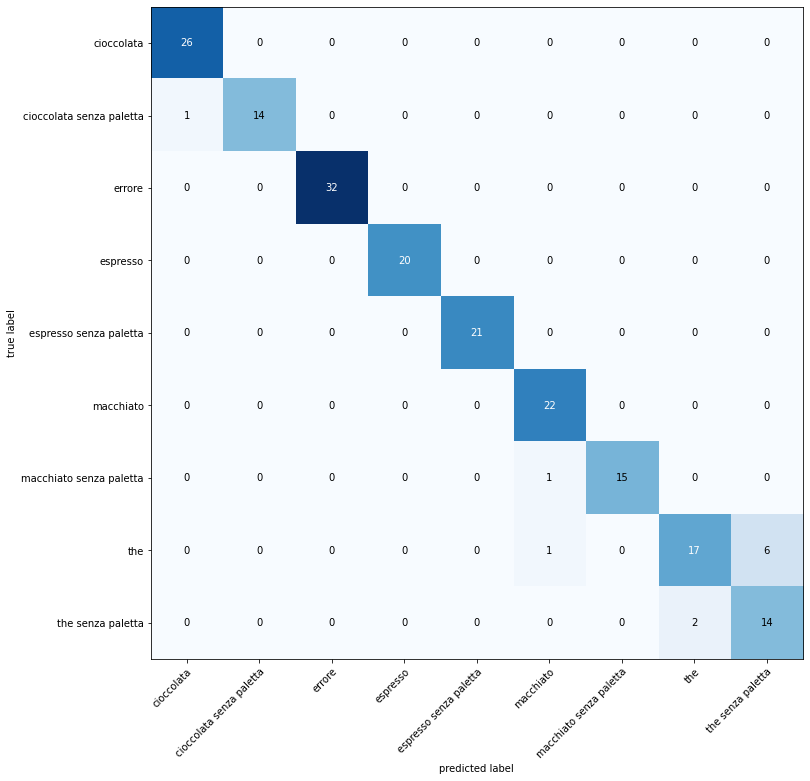

In [72]:
interpreter = tf.lite.Interpreter(model_path='saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')
interpreter.allocate_tensors()

quantized_accuracy = evaluate_lite_model(interpreter, testing_dataset, class_names=class_names, show_confusion_matrix=True)
print("Accuracy of compressed model model: %.2f" %(quantized_accuracy*100) , '%')

In [73]:
print("Original model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')
print("Quantized model size: ", get_zipped_model_size('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')/10**3, ' kB')

Original model size:  1.031874  MB
Quantized model size:  350.281  kB


## **Check for size and compression**

In [74]:
print("Original model size: ", get_zipped_model_size('saved_models/' + MODEL_NAME + '.keras')/10**6, ' MB')
print("Original model size: ", get_zipped_model_size('saved_models/' + PRUNED_MODEL_NAME + '.keras')/10**6, ' MB')
print("Quantized model size: ", get_zipped_model_size('saved_lite_models/' + QUANTIZED_MODEL_NAME + '.tflite')/10**3, ' kB')

Original model size:  2.014397  MB
Original model size:  1.031874  MB
Quantized model size:  350.281  kB


## **Test compressed model**

In [75]:
print('Accuracy: '          ,round(baseline_accuracy*100, 3), '%')
print('Pruned accuracy: '   ,round(100* pruned_accuracy,3) ,   '%')
print("Accuracy of compressed model model: %.2f" %(quantized_accuracy*100) , '%')

Accuracy:  97.396 %
Pruned accuracy:  98.438 %
Accuracy of compressed model model: 94.27 %
